# Libraries & Dataset

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import praw
from datetime import datetime, timezone
import csv
import matplotlib.cm as cm
import math
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community import greedy_modularity_communities
from matplotlib.lines import Line2D
from pandas.plotting import parallel_coordinates
from networkx.algorithms.centrality import betweenness_centrality, degree_centrality
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from collections import defaultdict


# Load the dataset
file_path = 'transfer_data_multiple_countries.csv'
data = pd.read_csv(file_path)


# Prelimantary Analysis

In this section we will be looking at the top 5 spending leagues and their top 3 clubs

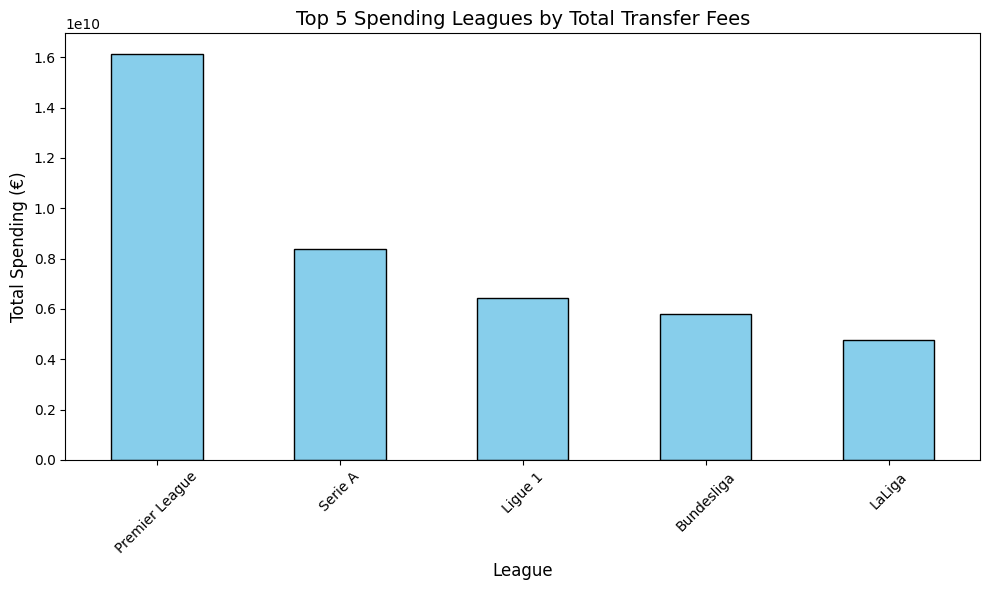

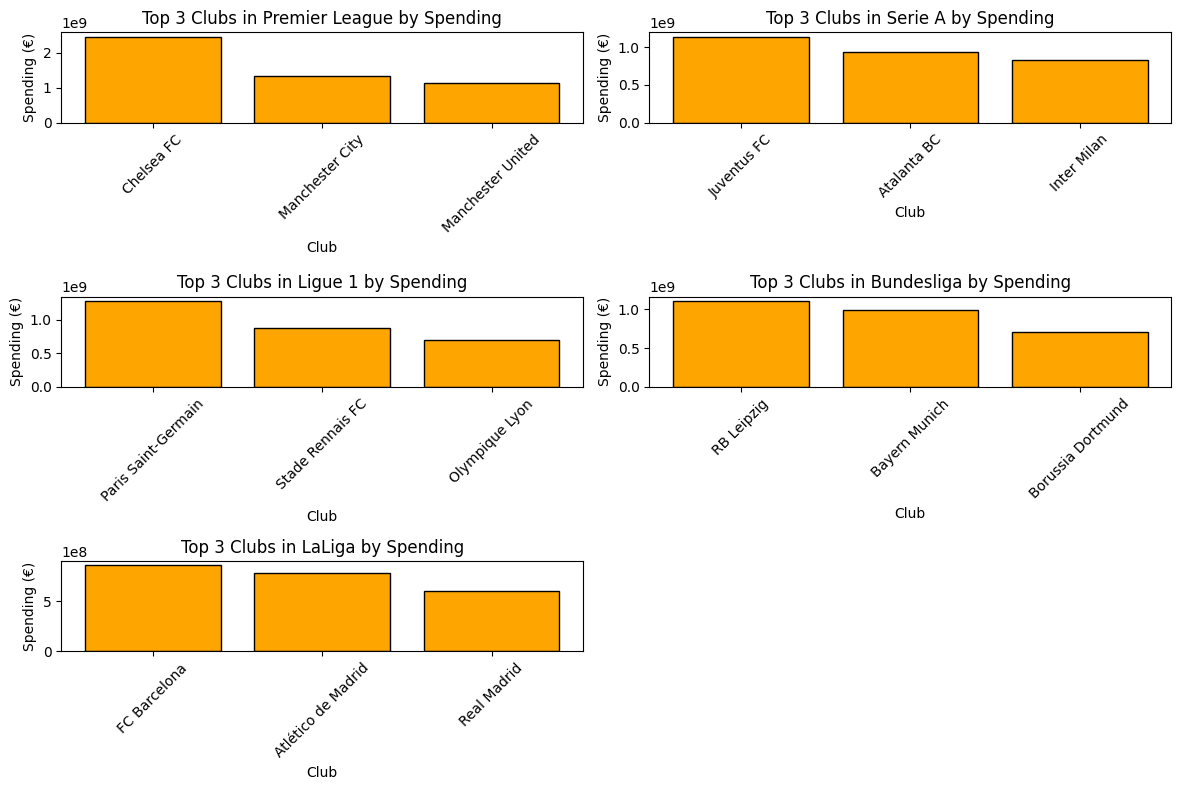

In [ ]:
# Calculate total transfer fees for each league
league_spending = data.groupby('league')['transfer_fee'].sum().sort_values(ascending=False)
top_leagues = league_spending.head(5)

# Filter out clubs from the top 5 leagues
top_league_clubs = data[data['league'].isin(top_leagues.index)]
top_club_spending = (
    top_league_clubs.groupby(['league', 'team_name'])['transfer_fee']
    .sum()
    .reset_index()
    .sort_values(by=['league', 'transfer_fee'], ascending=[True, False])
)
top_3_clubs_per_league = top_club_spending.groupby('league').head(3)

# Plot: Top 5 spending leagues
plt.figure(figsize=(10, 6))
league_spending[top_leagues.index].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 5 Spending Leagues by Total Transfer Fees", fontsize=14)
plt.ylabel("Total Spending (€)", fontsize=12)
plt.xlabel("League", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Top 3 clubs in each league by spending
plt.figure(figsize=(12, 8))
for i, league in enumerate(top_leagues.index, start=1):
    league_clubs = top_3_clubs_per_league[top_3_clubs_per_league['league'] == league]
    plt.subplot(3, 2, i)
    plt.bar(
        league_clubs['team_name'],
        league_clubs['transfer_fee'],
        color='orange',
        edgecolor='black'
    )
    plt.title(f"Top 3 Clubs in {league} by Spending", fontsize=12)
    plt.ylabel("Spending (€)", fontsize=10)
    plt.xlabel("Club", fontsize=10)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Visualizations - Transfer Fees by Player Position and Age
In this section we analyze and visulize transfer fees by player position and age

In [ ]:
# Create a network graph of player transfers
filtered_data = data.dropna(subset=['transfer_fee', 'player_age', 'player_position'])

# Filter for rows where the transfer is associated with the buying club
# Assuming 'transfer_type' identifies whether it's the buying or selling club
buying_club_data = filtered_data[filtered_data['transfer_type'] == 'Arrivals']

# hover_info: Additional information to display when hovering over a node
buying_club_data['hover_info'] = (
    "Player: " + buying_club_data['player_name'] +
    "<br>Buying Team: " + buying_club_data['team_name'] +
    "<br>Nationality: " + buying_club_data['player_nationality'] +
    "<br>Transfer Fee: €" + buying_club_data['transfer_fee'].astype(str)
)

# Interactive boxplot: Transfer fees by player position (updated hover info)
interactive_boxplot = px.box(
    buying_club_data,
    x='player_position',
    y='transfer_fee',
    title="Interactive Boxplot of Transfer Fees by Player Position",
    labels={'transfer_fee': 'Transfer Fee (€)', 'player_position': 'Player Position'},
    color='player_position',
    points="all",  # Show all points for better interaction
    hover_data={
        'player_name': True,
        'team_name': True,
        'player_nationality': True,
        'transfer_fee': True
    }
)
interactive_boxplot.update_layout(xaxis={'categoryorder': 'total descending'})
interactive_boxplot.show()

# Interactive heatmap: Correlation between player position, age, and transfer fees
heatmap_data = buying_club_data.groupby(['player_position', 'player_age']).agg({'transfer_fee': 'mean'}).reset_index()
interactive_heatmap = px.density_heatmap(
    heatmap_data,
    x='player_age',
    y='player_position',
    z='transfer_fee',
    title="Interactive Heatmap of Transfer Fee by Player Position and Age",
    labels={'player_age': 'Player Age', 'player_position': 'Player Position', 'transfer_fee': 'Avg Transfer Fee (€)'},
    color_continuous_scale='Viridis'
)
interactive_heatmap.show()


/var/folders/s5/1s5n05k56ds1wdhfq1bd19zc0000gn/T/ipykernel_80578/3261611849.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



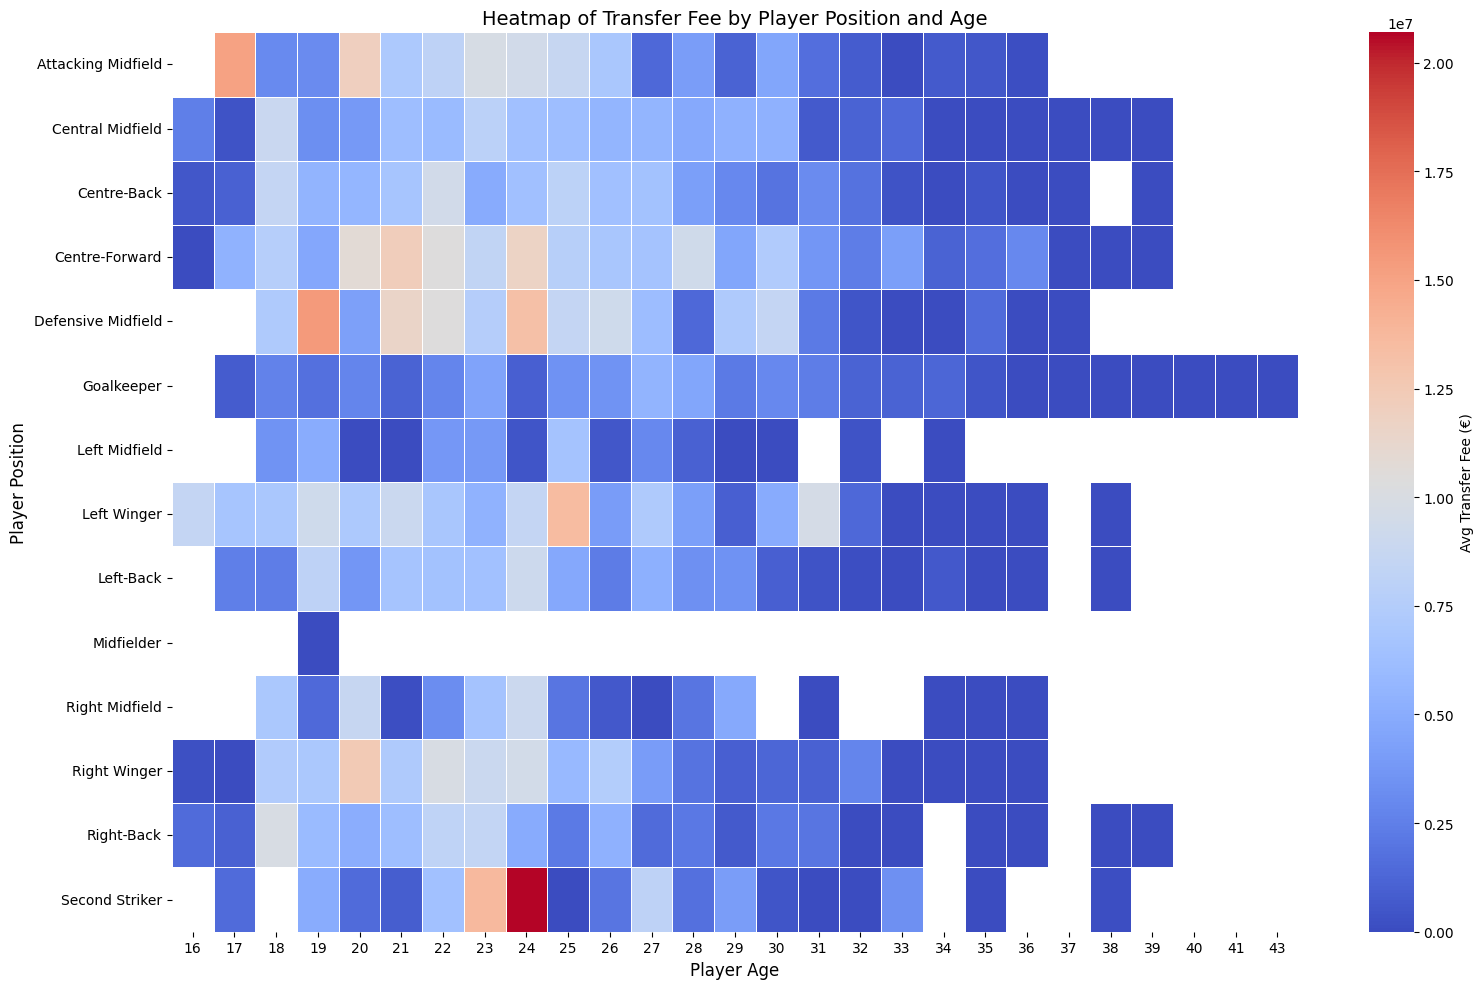

In [ ]:
# Heatmap: Correlation between player position, age, and transfer fees (unchanged)
heatmap_pivot = filtered_data.pivot_table(
    index='player_position',
    columns='player_age',
    values='transfer_fee',
    aggfunc='mean' 
)

plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_pivot,
    cmap='coolwarm',
    annot=False,
    linewidths=.5,
    cbar_kws={'label': 'Avg Transfer Fee (€)'}
)
plt.title("Heatmap of Transfer Fee by Player Position and Age", fontsize=14)
plt.xlabel("Player Age", fontsize=12)
plt.ylabel("Player Position", fontsize=12)
plt.tight_layout()
plt.show()

# Visualizations - Transfer Fees by Player Nationality
In this section we will visualize the distribution of transfer for player nationalities in the top leagues

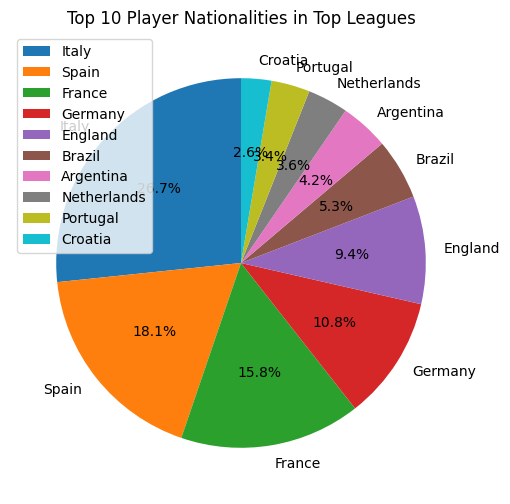

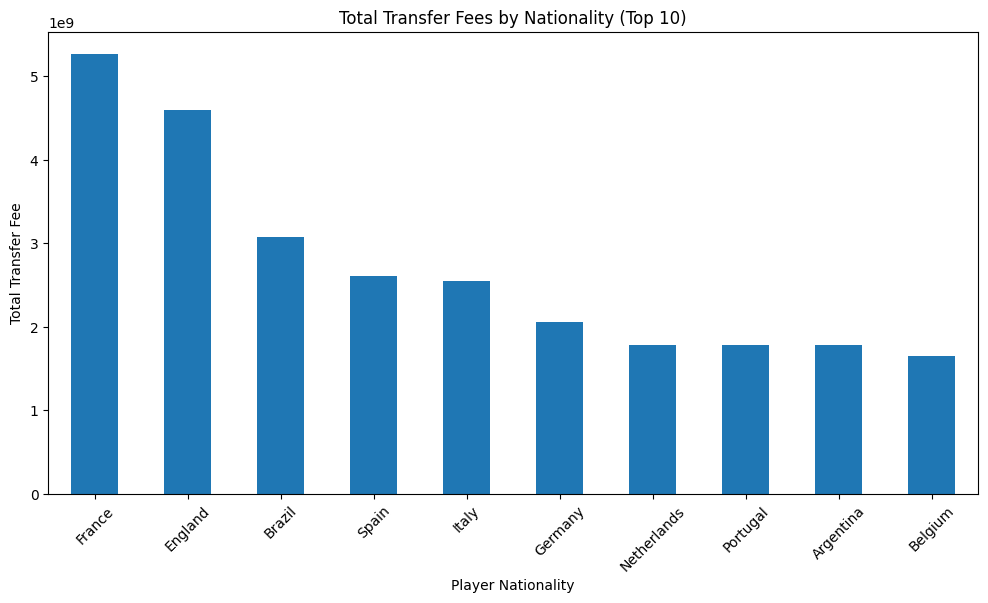

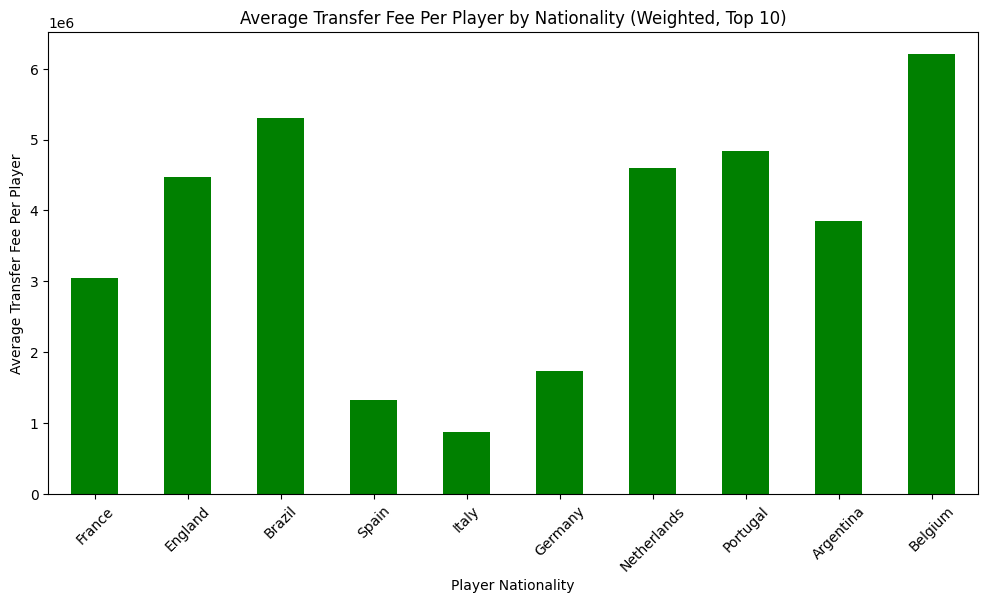

In [61]:
# Filter data for top leagues (assumed to be the Premier League, LaLiga, Bundesliga, Serie A, Ligue 1)
top_leagues = ['Premier League', 'LaLiga', 'Bundesliga', 'Serie A', 'Ligue 1']
top_league_data = data[data['league'].isin(top_leagues)]

# 1. Distribution of player nationalities in the top leagues
nationality_counts = top_league_data['player_nationality'].value_counts()

# Pie chart for distribution of player nationalities
plt.figure(figsize=(10, 6))
nationality_counts.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=True)
plt.title('Top 10 Player Nationalities in Top Leagues')
plt.ylabel('')  # Remove y-label for better appearance
plt.show()

# 2. Average transfer fees by nationality
# Calculate total transfer fees and number of players transferred for each nationality
nationality_transfer_stats = top_league_data.groupby('player_nationality').agg(
    total_transfer_fees=('transfer_fee', 'sum'),
    player_count=('player_name', 'count')
).sort_values(by='total_transfer_fees', ascending=False)

# Bar chart for total transfer fees by nationality (top 10)
plt.figure(figsize=(12, 6))
nationality_transfer_stats['total_transfer_fees'].head(10).plot(kind='bar')
plt.title('Total Transfer Fees by Nationality (Top 10)')
plt.xlabel('Player Nationality')
plt.ylabel('Total Transfer Fee')
plt.xticks(rotation=45)
plt.show()

# Optional: Normalize the total fees by player count to get the average *weighted by number of transfers*
nationality_transfer_stats['avg_transfer_fee_per_player'] = (
    nationality_transfer_stats['total_transfer_fees'] / nationality_transfer_stats['player_count']
)

# Bar chart for weighted average transfer fees per player by nationality (top 10)
plt.figure(figsize=(12, 6))
nationality_transfer_stats['avg_transfer_fee_per_player'].head(10).plot(kind='bar', color='green')
plt.title('Average Transfer Fee Per Player by Nationality (Weighted, Top 10)')
plt.xlabel('Player Nationality')
plt.ylabel('Average Transfer Fee Per Player')
plt.xticks(rotation=45)
plt.show()



In [62]:
# 2. Average transfer fees by nationality
avg_transfer_fees = top_league_data.groupby('player_nationality')['transfer_fee'].mean().sort_values(ascending=False)
# Get the top 10 nationalities by average transfer fees
top_10_nationalities = avg_transfer_fees.head(10).index

# Filter the data for players belonging to the top 10 nationalities
top_nationalities_data = top_league_data[top_league_data['player_nationality'].isin(top_10_nationalities)]

# Group by nationality and sort each group by transfer fee in descending order
top_players_by_nationality = (
    top_nationalities_data.groupby('player_nationality')
    .apply(lambda group: group.nlargest(3, 'transfer_fee'))
    .reset_index(drop=True)
)

# Display the top players data
print("Top 3 Most Expensive Players by Nationality in Top Leagues")
print(top_players_by_nationality)


Top 3 Most Expensive Players by Nationality in Top Leagues
                 team_name          league  country  season transfer_type  \
0               Chelsea FC  Premier League  England    2021      Arrivals   
1              Inter Milan         Serie A    Italy    2021    Departures   
2               Chelsea FC  Premier League  England    2023      Arrivals   
3        Manchester United  Premier League  England    2022      Arrivals   
4      Paris Saint-Germain         Ligue 1   France    2023    Departures   
5             FC Barcelona          LaLiga    Spain    2020    Departures   
6                 OGC Nice         Ligue 1   France    2022      Arrivals   
7               Chelsea FC  Premier League  England    2023      Arrivals   
8   Brighton & Hove Albion  Premier League  England    2023    Departures   
9      Eintracht Frankfurt      Bundesliga  Germany    2024    Departures   
10         Manchester City  Premier League  England    2021      Arrivals   
11             As

/var/folders/s5/1s5n05k56ds1wdhfq1bd19zc0000gn/T/ipykernel_80578/3309762618.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Number of players after filtering: 142


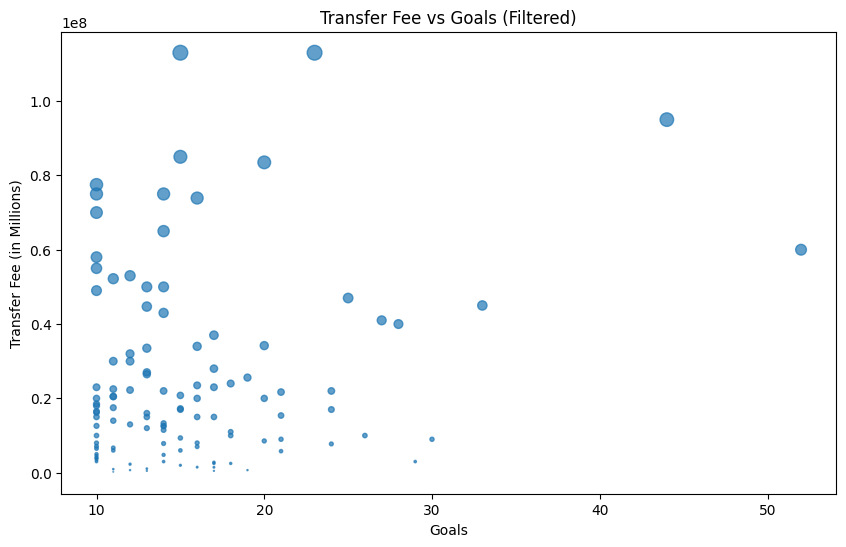

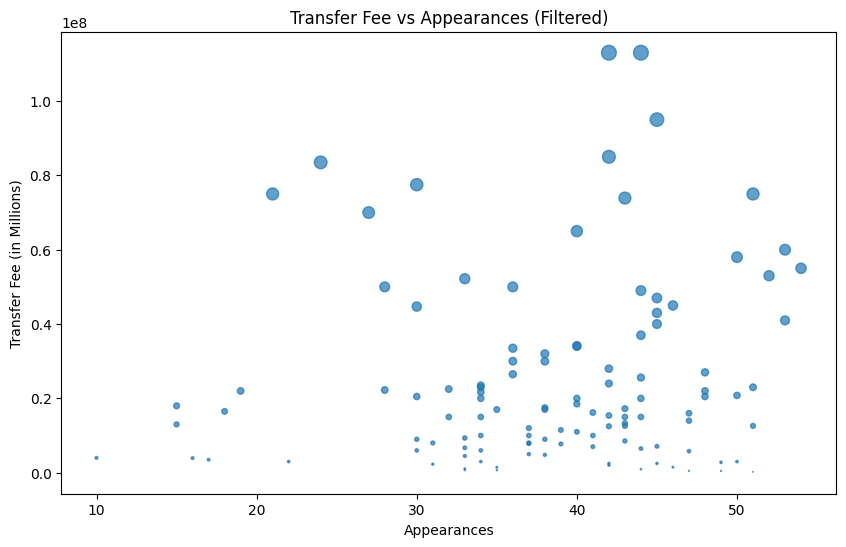

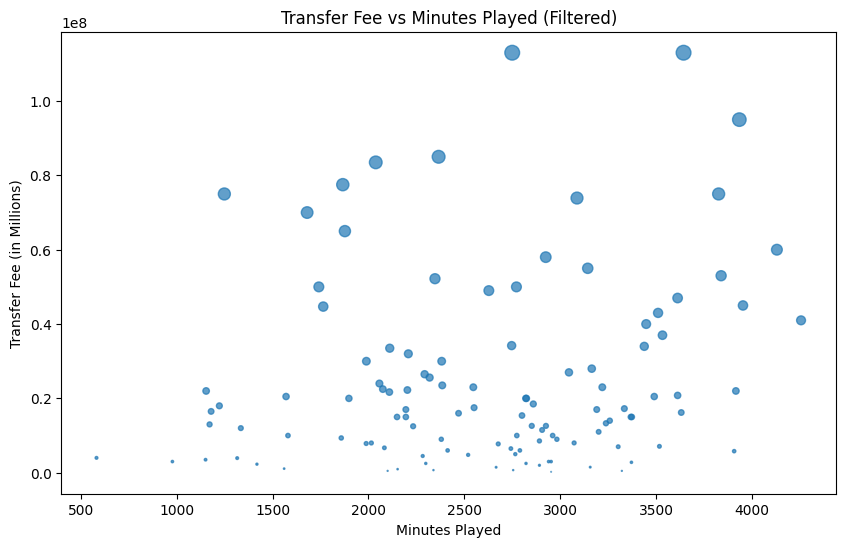

Standout players based on transfer fees and performance metrics:
                     player_name  goals  appearances  minutes_played  \
86                   Timo Werner   12.0         52.0          3840.0   
792                Romelu Lukaku   15.0         44.0          2750.0   
1414              Erling Haaland   52.0         53.0          4131.0   
1606                Darwin Núñez   15.0         42.0          2366.0   
2245                 Kai Havertz   14.0         51.0          3827.0   
2460                Moussa Diaby   10.0         54.0          3144.0   
4996          Robert Lewandowski   33.0         46.0          3954.0   
5737             Jude Bellingham   23.0         42.0          3644.0   
6521              Julián Alvarez   10.0         21.0          1248.0   
7188                 André Silva   29.0         34.0          2953.0   
7689                 André Silva   17.0         51.0          3220.0   
8918                  Harry Kane   44.0         45.0          3935.0   

In [63]:
# Filter out rows with NA values in performance metrics and transfer fees
performance_data = top_league_data.dropna(subset=['transfer_fee', 'goals', 'appearances', 'minutes_played'])

# Filter out players with less than 10 goals or less than 10 appearances
filtered_data = performance_data[
    (performance_data['goals'] >= 10) & (performance_data['appearances'] >= 10)
]

# Print the number of players after filtering
num_filtered_players = filtered_data.shape[0]
print(f"Number of players after filtering: {num_filtered_players}")

# Scatter plots for performance metrics vs. market value (transfer fee)
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['goals'], filtered_data['transfer_fee'], alpha=0.7, label='Goals', s=filtered_data['transfer_fee'] / 1e6)
plt.title('Transfer Fee vs Goals (Filtered)')
plt.xlabel('Goals')
plt.ylabel('Transfer Fee (in Millions)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['appearances'], filtered_data['transfer_fee'], alpha=0.7, label='Appearances', s=filtered_data['transfer_fee'] / 1e6)
plt.title('Transfer Fee vs Appearances (Filtered)')
plt.xlabel('Appearances')
plt.ylabel('Transfer Fee (in Millions)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['minutes_played'], filtered_data['transfer_fee'], alpha=0.7, label='Minutes Played', s=filtered_data['transfer_fee'] / 1e6)
plt.title('Transfer Fee vs Minutes Played (Filtered)')
plt.xlabel('Minutes Played')
plt.ylabel('Transfer Fee (in Millions)')
plt.show()

# Identify standout players
# Standouts are defined as players with top 5% transfer fees or top performance metrics
transfer_fee_threshold = filtered_data['transfer_fee'].quantile(0.95)
goals_threshold = filtered_data['goals'].quantile(0.95)
appearances_threshold = filtered_data['appearances'].quantile(0.95)

standout_players = filtered_data[
    (filtered_data['transfer_fee'] >= transfer_fee_threshold) |
    (filtered_data['goals'] >= goals_threshold) |
    (filtered_data['appearances'] >= appearances_threshold)
]

# Display standout players
print("Standout players based on transfer fees and performance metrics:")
print(standout_players[['player_name', 'goals', 'appearances', 'minutes_played', 'transfer_fee']])


In [64]:
# Prepare data for interactive visualization
interactive_data = filtered_data[['player_name', 'goals', 'appearances', 'minutes_played', 'transfer_fee']]

# Create a 3D scatter plot
fig = px.scatter_3d(
    interactive_data,
    x='goals',
    y='appearances',
    z='minutes_played',
    color='transfer_fee',
    size='transfer_fee',
    hover_data=['player_name'],
    title='Interactive 3D Scatter: Goals, Appearances, Minutes vs Transfer Fee',
    labels={'transfer_fee': 'Transfer Fee (€)', 'goals': 'Goals', 'appearances': 'Appearances'}
)

# Show the interactive plot
fig.show()


In [65]:
# Create a scatter plot for Goals vs Transfer Fee
fig = px.scatter(
    interactive_data,
    x='goals',
    y='transfer_fee',
    size='transfer_fee',
    color='transfer_fee',
    hover_data=['player_name', 'appearances', 'minutes_played'],
    title='Interactive Scatter: Goals vs Transfer Fee',
    labels={'transfer_fee': 'Transfer Fee (€)', 'goals': 'Goals'}
)
fig.update_traces(marker=dict(opacity=0.8))
fig.show()

# Similarly, create plots for other metrics (e.g., appearances, minutes)


/var/folders/s5/1s5n05k56ds1wdhfq1bd19zc0000gn/T/ipykernel_80578/1127195265.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/s5/1s5n05k56ds1wdhfq1bd19zc0000gn/T/ipykernel_80578/1127195265.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



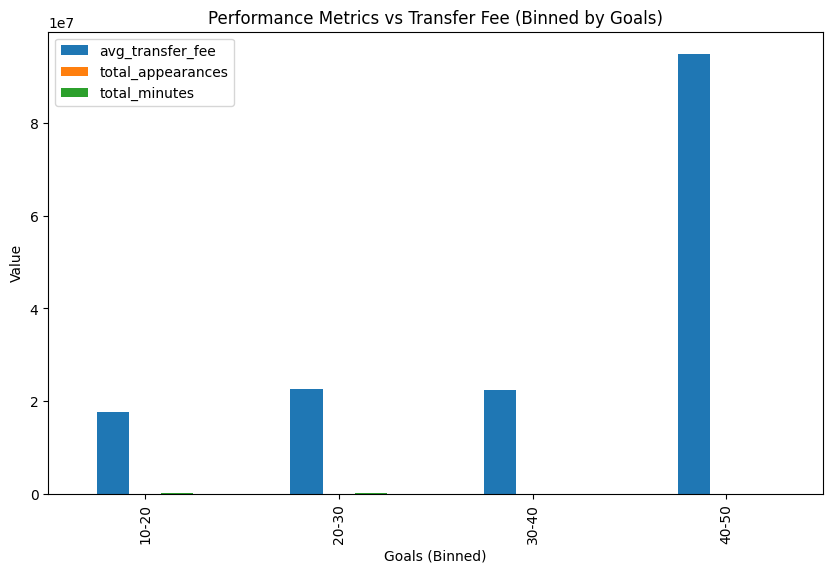

In [66]:
filtered_data['goal_bins'] = pd.cut(filtered_data['goals'], bins=[10, 20, 30, 40, 50], labels=['10-20', '20-30', '30-40', '40-50'])
grouped_data = filtered_data.groupby('goal_bins').agg(
    avg_transfer_fee=('transfer_fee', 'mean'),
    total_appearances=('appearances', 'sum'),
    total_minutes=('minutes_played', 'sum')
).reset_index()

# Bar Chart
grouped_data.plot(
    x='goal_bins', 
    y=['avg_transfer_fee', 'total_appearances', 'total_minutes'], 
    kind='bar', figsize=(10, 6))
plt.title('Performance Metrics vs Transfer Fee (Binned by Goals)')
plt.ylabel('Value')
plt.xlabel('Goals (Binned)')
plt.show()


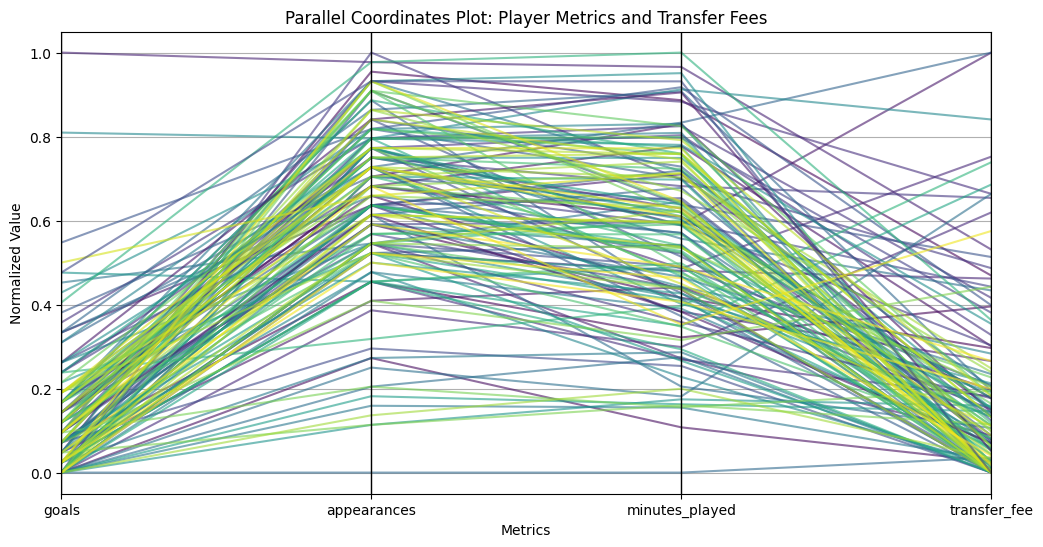

In [67]:
# Normalize the data for better visualization
normalized_data = filtered_data[['goals', 'appearances', 'minutes_played', 'transfer_fee']].copy()
normalized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
normalized_data['player_name'] = filtered_data['player_name']

# Parallel coordinates plot
plt.figure(figsize=(12, 6))
parallel_coordinates(normalized_data, 'player_name', colormap=plt.cm.viridis, alpha=0.6)
plt.title('Parallel Coordinates Plot: Player Metrics and Transfer Fees')
plt.xlabel('Metrics')
plt.ylabel('Normalized Value')
plt.legend([], frameon=False)  # Hide legend for clarity
plt.show()


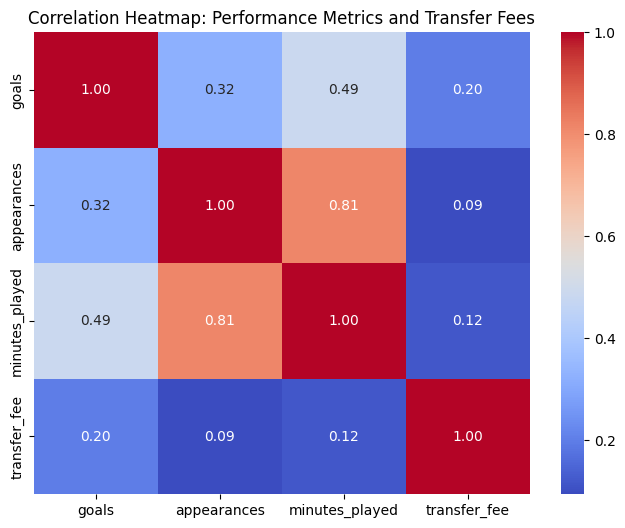

In [68]:
# Correlation matrix
corr_matrix = filtered_data[['goals', 'appearances', 'minutes_played', 'transfer_fee']].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap: Performance Metrics and Transfer Fees')
plt.show()


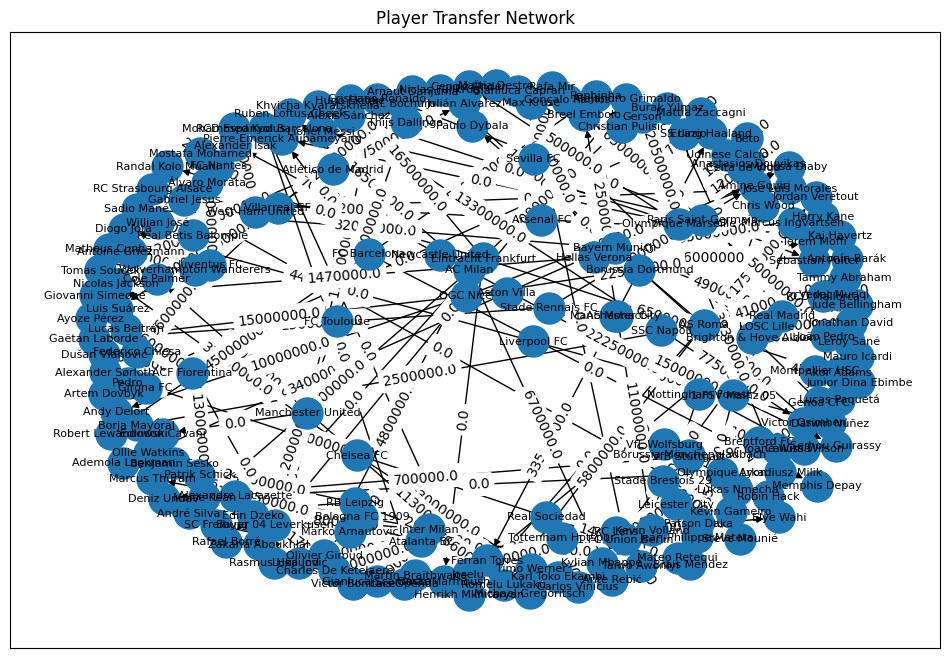

In [69]:
# Create a directed graph
G = nx.DiGraph()

# Add edges: From one team to another for each transfer
for _, row in filtered_data.iterrows():
    G.add_edge(row['team_name'], row['player_name'], weight=row['transfer_fee'], season=row['season'])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Layout for better visualization
nx.draw_networkx(G, pos, with_labels=True, node_size=500, font_size=8)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Player Transfer Network')
plt.show()


In [70]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G)

# Display top teams or players by centrality
print("Top Teams/Players by Degree Centrality:", sorted(degree_centrality.items(), key=lambda x: -x[1])[:10])
print("Top Teams/Players by Betweenness Centrality:", sorted(betweenness_centrality.items(), key=lambda x: -x[1])[:10])
print("Top Teams/Players by PageRank:", sorted(pagerank.items(), key=lambda x: -x[1])[:10])


Top Teams/Players by Degree Centrality: [('Eintracht Frankfurt', 0.031914893617021274), ('AS Roma', 0.031914893617021274), ('Atalanta BC', 0.026595744680851064), ('Olympique Marseille', 0.026595744680851064), ('Chelsea FC', 0.02127659574468085), ('FC Barcelona', 0.02127659574468085), ('Villarreal CF', 0.02127659574468085), ('RB Leipzig', 0.02127659574468085), ('AC Milan', 0.02127659574468085), ('ACF Fiorentina', 0.02127659574468085)]
Top Teams/Players by Betweenness Centrality: [('Manchester City', 0.0), ('Ferran Torres', 0.0), ('Liverpool FC', 0.0), ('Diogo Jota', 0.0), ('Chelsea FC', 0.0), ('Timo Werner', 0.0), ('Manchester United', 0.0), ('Edinson Cavani', 0.0), ('Tottenham Hotspur', 0.0), ('Carlos Vinícius', 0.0)]
Top Teams/Players by PageRank: [('Serhou Guirassy', 0.010286865555027096), ('Taiwo Awoniyi', 0.009748341367186875), ('Romelu Lukaku', 0.008779945752265164), ('Rasmus Højlund', 0.008017326133276654), ('Carlos Vinícius', 0.007791295797787415), ('Patson Daka', 0.007791295797

In [71]:
# Detect communities
communities = greedy_modularity_communities(G)
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")


Community 1: frozenset({'Timo Werner', 'Chelsea FC', 'Tammy Abraham', 'Edin Dzeko', 'Borja Mayoral', 'Inter Milan', 'Romelu Lukaku', 'Jordan Veretout', 'Henrikh Mkhitaryan', 'AS Roma', 'Cole Palmer', 'Nicolas Jackson', 'Paulo Dybala', 'Marcus Thuram'})
Community 2: frozenset({'Benjamin Sesko', 'Rafael Borré', 'André Silva', 'Randal Kolo Muani', 'Junior Dina Ebimbe', 'Elye Wahi', 'Omar Marmoush', 'Hugo Ekitiké', 'Loïs Openda', 'RC Lens', 'Eintracht Frankfurt', 'RB Leipzig'})
Community 3: frozenset({'Amine Gouiri', 'Gaëtan Laborde', 'OGC Nice', 'VfB Stuttgart', 'Terem Moffi', 'Borussia Dortmund', 'Niclas Füllkrug', 'Deniz Undav', 'Serhou Guirassy', 'Andy Delort', 'Stade Rennais FC'})
Community 4: frozenset({'Raphinha', 'Olympique Marseille', 'Alexis Sánchez', 'Memphis Depay', 'FC Barcelona', 'Gerson', 'Cengiz Ünder', 'Arkadiusz Milik', 'Pierre-Emerick Aubameyang', 'Robert Lewandowski'})
Community 5: frozenset({'Ademola Lookman', 'Atalanta BC', 'Charles De Ketelaere', 'Mateo Retegui', 'Ma

In [72]:
# Example: Find shortest path between two teams
team_a = "Manchester City"
team_b = "Chelsea FC"
if nx.has_path(G, team_a, team_b):
    shortest_path = nx.shortest_path(G, source=team_a, target=team_b)
    print(f"Shortest transfer path from {team_a} to {team_b}: {shortest_path}")


In [73]:
# Create season-wise graphs
seasons = filtered_data['season'].unique()
for season in seasons:
    season_data = filtered_data[filtered_data['season'] == season]
    G_season = nx.DiGraph()
    for _, row in season_data.iterrows():
        G_season.add_edge(row['team_name'], row['player_name'], weight=row['transfer_fee'])
    print(f"Season {season}: Nodes={len(G_season.nodes())}, Edges={len(G_season.edges())}")


Season 2020: Nodes=59, Edges=32
Season 2021: Nodes=54, Edges=29
Season 2022: Nodes=65, Edges=35
Season 2023: Nodes=70, Edges=39
Season 2024: Nodes=14, Edges=7


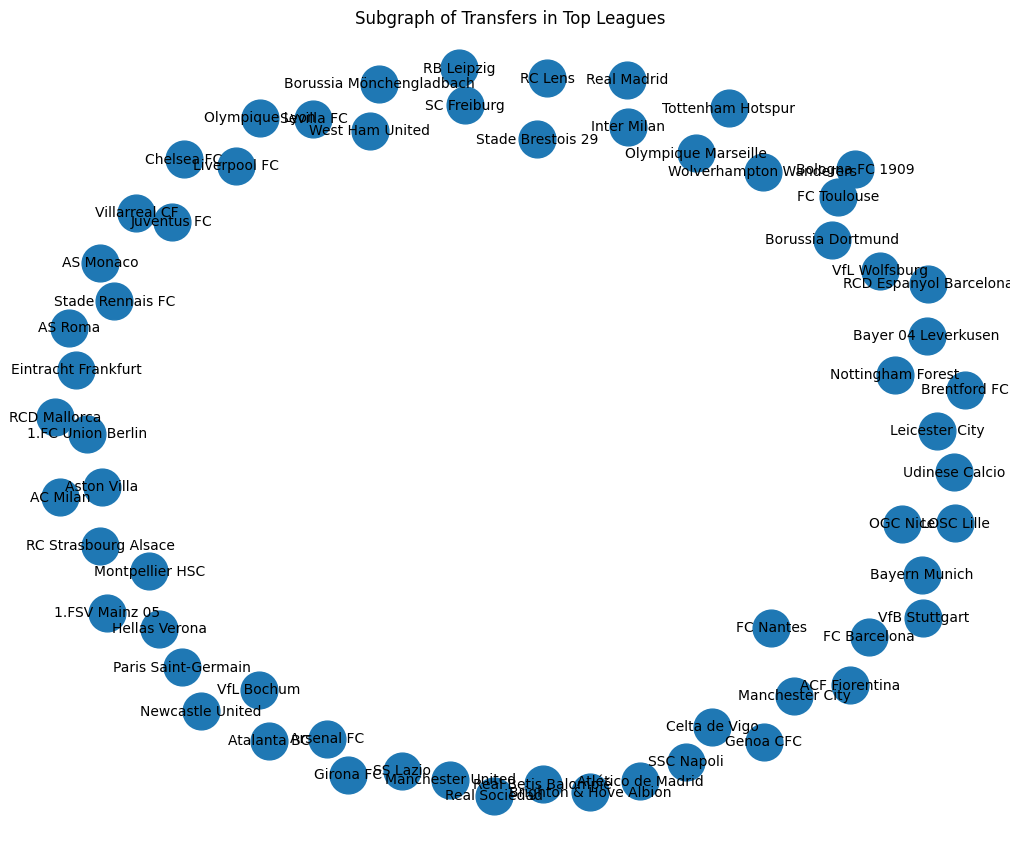

In [74]:
# Filter subgraph for top leagues
top_league_teams = filtered_data[filtered_data['league'].isin(top_leagues)]['team_name'].unique()
subgraph = G.subgraph(top_league_teams)

# Draw the subgraph
plt.figure(figsize=(10, 8))
nx.draw(subgraph, with_labels=True, node_size=700, font_size=10)
plt.title('Subgraph of Transfers in Top Leagues')
plt.show()


In [75]:
# Convert directed graph to undirected graph
G_undirected = G.to_undirected()

# Check connectivity and compute diameter
if nx.is_connected(G_undirected):
    diameter = nx.diameter(G_undirected)
else:
    diameter = "Graph is not connected"

# Compute density and clustering coefficient
density = nx.density(G_undirected)
clustering_coefficient = nx.average_clustering(G_undirected)

print(f"Network Density: {density}")
print(f"Network Diameter: {diameter}")
print(f"Average Clustering Coefficient: {clustering_coefficient}")


Network Density: 0.00799279522683778
Network Diameter: Graph is not connected
Average Clustering Coefficient: 0.0


# Network analysis

Nodes are teams, and the edges are the transfers that connect the two

Number of Nodes (Teams): 1154
Number of Edges (Transfers): 5891

Top 10 Teams by Total Transfer Activity:
Chelsea FC: 1335240000.00
RB Leipzig: 1283920000.00
Bayern Munich: 1203520000.00
Aston Villa: 1074260000.00
Atalanta BC: 1062368500.00
Real Madrid: 986800000.00
Manchester City: 869570000.00
Manchester United: 834360000.00
Chelsea: 830100000.00
Olympique Lyon: 805230000.00


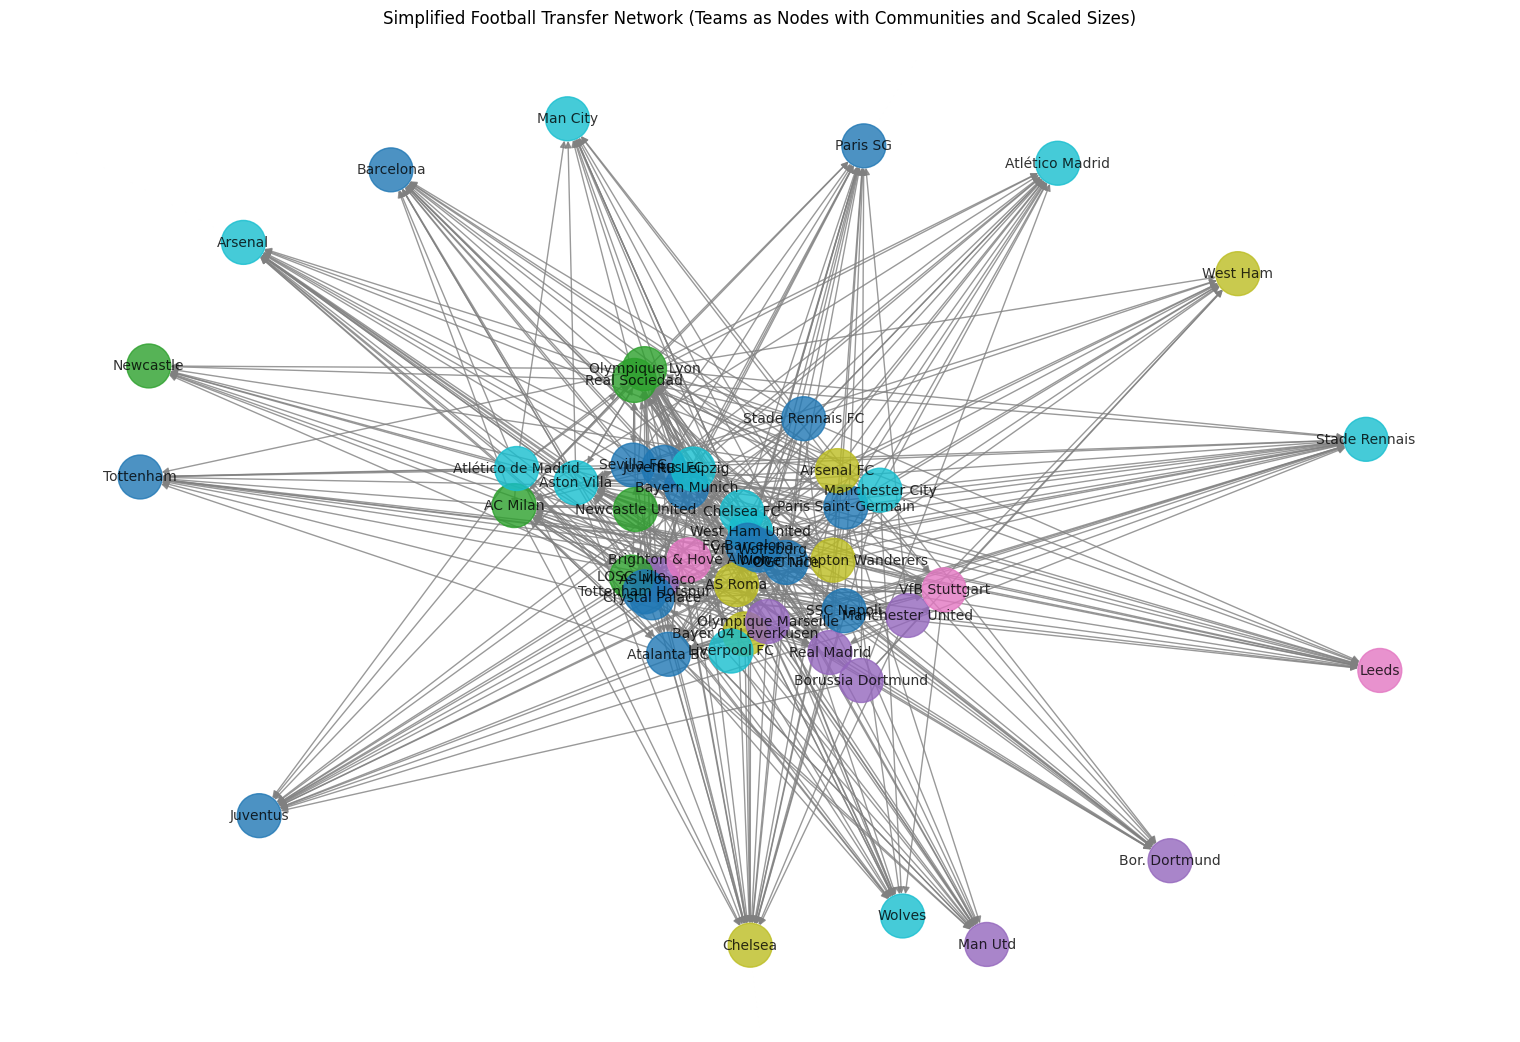

In [76]:
# Step 1: Create the directed graph
team_graph = nx.DiGraph()

# Add edges between teams with weights as transfer fees
filtered_team_data = data.dropna(subset=['team_name', 'club_2', 'transfer_fee'])
for _, row in filtered_team_data.iterrows():
    team_graph.add_edge(
        row['team_name'], 
        row['club_2'], 
        weight=row['transfer_fee']
    )

# Step 2: Compute network metrics
team_weighted_degree = team_graph.degree(weight='weight')
sorted_team_degree = sorted(team_weighted_degree, key=lambda x: x[1], reverse=True)

print(f"Number of Nodes (Teams): {team_graph.number_of_nodes()}")
print(f"Number of Edges (Transfers): {team_graph.number_of_edges()}")
print("\nTop 10 Teams by Total Transfer Activity:")
for team, weight in sorted_team_degree[:10]:
    print(f"{team}: {weight:.2f}")

# Step 3: Simplify the graph (keep top teams only)
top_teams = [node for node, centrality in sorted_team_degree[:50]]  # Top 50 teams by activity
simplified_team_graph = team_graph.subgraph(top_teams)

# Step 4: Detect communities
communities = louvain_communities(simplified_team_graph, weight='weight')
community_mapping = {node: i for i, community in enumerate(communities) for node in community}
node_colors = [community_mapping[node] for node in simplified_team_graph.nodes()]

# Step 5: Adjust node sizes based on weighted degree
# Scale size for better visualization
node_sizes = [1000 + 2000 * simplified_team_graph.degree[node] / max(dict(team_weighted_degree).values()) for node in simplified_team_graph.nodes()]

# Step 6: Visualize the simplified graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(simplified_team_graph, seed=42)
nx.draw(
    simplified_team_graph, pos, with_labels=True, node_size=node_sizes, font_size=10,
    node_color=node_colors, cmap=cm.tab10, edge_color='gray', alpha=0.8
)
plt.title("Simplified Football Transfer Network (Teams as Nodes with Communities and Scaled Sizes)")
plt.show()


The visualization represents the football transfer network with teams as nodes, highlighting their connections through player transfers. The size of each node reflects the total value of transfers (weighted degree), showcasing influential teams like Manchester City, Chelsea, and Paris Saint-Germain as key players in the market. The nodes are color-coded to represent communities detected through their transfer relationships, revealing clusters of closely connected teams, often within the same league or region. Edges indicate transfer activity, with denser areas reflecting higher interaction between teams. This structure highlights the interconnected nature of football transfers, where dominant clubs act as major hubs, and certain teams bridge different clusters, facilitating international player movement. The network underscores the economic and competitive influence of top clubs and provides insights into league-specific and cross-league transfer dynamics.

# Communitites

### Detect League-Specific Communities

Treat each league as a node and connect them with weighted edges based on the number of players transferred between them.
Apply a community detection algorithm like Louvain

In [77]:
# Create a league-level graph
league_graph = nx.DiGraph()

# Add edges between leagues with weights as transfer fees
filtered_league_data = data.dropna(subset=['league', 'league_2', 'transfer_fee'])
for _, row in filtered_league_data.iterrows():
    league_graph.add_edge(
        row['league'], 
        row['league_2'], 
        weight=row['transfer_fee']
    )

# Calculate centrality metrics
degree_centrality_scores = nx.degree_centrality(league_graph)  # In+Out degree centrality
in_degree_centrality_scores = league_graph.in_degree(weight='weight')  # Weighted in-degree
out_degree_centrality_scores = league_graph.out_degree(weight='weight')  # Weighted out-degree
betweenness_centrality_scores = nx.betweenness_centrality(league_graph, weight='weight')  # Betweenness centrality

# Sort leagues by centrality scores
sorted_degree = sorted(degree_centrality_scores.items(), key=lambda x: x[1], reverse=True)
sorted_in_degree = sorted(in_degree_centrality_scores, key=lambda x: x[1], reverse=True)
sorted_out_degree = sorted(out_degree_centrality_scores, key=lambda x: x[1], reverse=True)
sorted_betweenness = sorted(betweenness_centrality_scores.items(), key=lambda x: x[1], reverse=True)

# Print top leagues for each metric
print("Top Leagues by Degree Centrality:")
for league, score in sorted_degree[:10]:
    print(f"{league}: {score:.4f}")

print("\nTop Leagues by Weighted In-Degree (Importing Talent):")
for league, score in sorted_in_degree[:10]:
    print(f"{league}: {score:.2f}")

print("\nTop Leagues by Weighted Out-Degree (Exporting Talent):")
for league, score in sorted_out_degree[:10]:
    print(f"{league}: {score:.2f}")

print("\nTop Leagues by Betweenness Centrality (Influence):")
for league, score in sorted_betweenness[:10]:
    print(f"{league}: {score:.4f}")


Top Leagues by Degree Centrality:
Serie A: 0.7134
Ligue 1: 0.6280
Bundesliga: 0.5122
Premier League: 0.4329
LaLiga: 0.4268
Serie B: 0.3963
Ligue 2: 0.3659
LaLiga2: 0.3171
2. Bundesliga: 0.3049
Championship: 0.2744

Top Leagues by Weighted In-Degree (Importing Talent):
Bundesliga: 66200000.00
LaLiga: 64400000.00
Premiership: 53100000.00
Eredivisie: 49900000.00
Premier League: 41900000.00
Challenger Pro League: 41100000.00
Premier League 2: 39050000.00
Premier Liga: 38300000.00
Super League: 36445000.00
Liga Portugal: 36300000.00

Top Leagues by Weighted Out-Degree (Exporting Talent):
Premier League: 277830000.00
Ligue 1: 184374000.00
Championship: 125400000.00
Bundesliga: 117350000.00
Serie A: 107770000.00
LaLiga: 98062000.00
Ligue 2: 81200000.00
Serie B: 60546000.00
2. Bundesliga: 51330000.00
LaLiga2: 44400000.00

Top Leagues by Betweenness Centrality (Influence):
Ligue 1: 0.3374
Premier League: 0.1450
Championship: 0.1296
LaLiga2: 0.0998
LaLiga: 0.0861
3. Liga: 0.0606
2. Bundesliga: 0

# Reddit

In this section, we will retrive data on certain football players from the R/Soccer subreddit. We will use this data to conduct a textual analysis and TD-IDF

In [ ]:
# Replace these with your actual credentials
CLIENT_ID = "iXwJeKl0KJXTptbjW8ZoJg"
CLIENT_SECRET = "iGz4rJZ7R_l33esEkO5S37Sg6J0PEA"
USER_AGENT = "keyword_search_script by u/Other_Dig1282"

def fetch_all_comments(submission):
    """
    Fetch all comments from a submission and return them as a single string (one line).
    """
    submission.comments.replace_more(limit=None)
    all_comments = []
    for comment in submission.comments.list():
        # Replace newlines in comment body with spaces
        cleaned_body = comment.body.replace('\n', ' ')
        all_comments.append(cleaned_body)
    # Join all comments with a space instead of newlines
    return " ".join(all_comments)

def search_with_time_filter(subreddit_name, keyword, time_filter='year', limit=2000, filename="default.csv"):
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT
    )
    subreddit = reddit.subreddit(subreddit_name)
    
    print(f"Searching for '{keyword}' in r/{subreddit_name} with time_filter='{time_filter}'...")

    # Collect all results
    all_results = list(subreddit.search(keyword, sort='relevance', time_filter=time_filter, limit=limit))
    
    if not all_results:
        print("No posts found at all.")
        return

    print("\nAll Retrieved Posts:")
    rows = []
    for submission in all_results:
        submission_date = datetime.fromtimestamp(submission.created_utc, tz=timezone.utc)
        post_url = f"https://www.reddit.com{submission.permalink}"
        content = submission.selftext if submission.selftext else "[No textual content]"

        print(f"Title: {submission.title}")
        print(f"Created (UTC): {submission_date.isoformat()}")
        print(f"URL: {submission.url}")
        print(f"Reddit Post URL: {post_url}")
        print("Content:")
        print(content)
        
        # Fetch all comments for this submission
        print("Fetching comments...")
        comments_text = fetch_all_comments(submission)
        print(f"Number of comments fetched: {len(comments_text.split())}")
        print("-" * 40)
        
        # Prepare row for CSV
        rows.append({
            "title": submission.title,
            "created_utc": submission_date.isoformat(),
            "reddit_post_url": post_url,
            "content": content,
            "score": submission.score,
            "author": str(submission.author),
            "url": submission.url,
            "comments": comments_text
        })

    # Save all results to CSV
    csv_filename = filename
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ["title", "created_utc", "reddit_post_url", "content", "score", "author", "url", "comments"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quoting=csv.QUOTE_ALL)
        writer.writeheader()
        writer.writerows(rows)

    print(f"\nData saved to {csv_filename}")

if __name__ == "__main__":
    # Example usage
    search_with_time_filter("Soccer", "Mbappe transfer", time_filter='year', limit=20, filename="Mbappe_transfer.csv")
    search_with_time_filter("Soccer", "Olmo transfer", time_filter='year', limit=20, filename="Olmo_transfer.csv")
    search_with_time_filter("Soccer", "Diaby transfer", time_filter='year', limit=20, filename="Diaby_transfer.csv")
    search_with_time_filter("Soccer", "Yoro transfer", time_filter='year', limit=20, filename="Yoro_transfer.csv")
    search_with_time_filter("Soccer", "Solanke transfer", time_filter='year', limit=20, filename="Solanke_transfer.csv")
    search_with_time_filter("Soccer", "De Ligt transfer", time_filter='year', limit=20, filename="Deligt_transfer.csv")
    search_with_time_filter("Soccer", "Douglas Luiz transfer", time_filter='year', limit=20, filename="DL_transfer.csv")
    search_with_time_filter("Soccer", "Julian Alvarez transfer", time_filter='year', limit=20, filename="Alvarez_transfer.csv")
    search_with_time_filter("Soccer", "Pedro Neto transfer", time_filter='year', limit=20, filename="Pedro_transfer.csv")


# TF-IDF Analysis
We will use TF-IDF to analyze the words most associated with certain players

In [ ]:
file_paths = {
    "Alvarez_transfer": "reddits/Alvarez_transfer.csv",
    "Deligt_transfer": "reddits/Deligt_transfer.csv",
    "Diaby_transfer": "reddits/Diaby_transfer.csv",
    "DL_transfer": "reddits/DL_transfer.csv",
    "Mbappe_transfer": "reddits/Mbappe_transfer.csv",
    "Olmo_transfer": "reddits/Olmo_transfer.csv",
    "Pedro_transfer": "reddits/Pedro_transfer.csv",
    "Solanke_transfer": "reddits/Solanke_transfer.csv",
    "Yoro_transfer": "reddits/Yoro_transfer.csv"
}


dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}


In [ ]:
transfer_related_words = [
    "star", "talented", "exceptional", "promising", "rising", "skilled", 
    "proven", "versatile", "strong", "reliable", "world-class", "elite", 
    "experienced", "dynamic", "clutch", "outstanding", "fit", "bargain", 
    "steal", "genius", "value", "flop", "overrated", "risky", "gamble", 
    "injury-prone", "washed", "overpriced", "liability", "inconsistent", 
    "slow", "weak", "unfit", "bust", "disappointment", "problem", "poor", 
    "outdated", "fraud", "disaster", "waste", "exciting", "shocking", 
    "controversial", "surprising", "heartbreaking", "frustrating", "thrilling",
    "emotional", "dramatic", "unbelievable", "disgraceful", "insane", 
    "ridiculous", "crazy", "unexpected", "massive", "bold", "questionable",
    "regretful", "heated"
]

comprehensive_ignore_words = [
    "the", "a", "an", "and", "but", "or", "nor", "for", "yet", "so", 
    "in", "on", "at", "by", "with", "about", "against", "between", "into", 
    "through", "during", "before", "after", "over", "under", "to", "from", 
    "up", "down", "out", "off", "of", "like", "i", "you", "he", "she", 
    "it", "we", "they", "me", "him", "her", "us", "them", "my", "your", 
    "his", "its", "our", "their", "mine", "yours", "hers", "theirs", "is", 
    "was", "are", "were", "will", "would", "should", "could", "has", 
    "have", "had", "do", "does", "did", "can", "may", "might", "am", "be", 
    "being", "been", "if", "then", "there", "here", "this", "that", "these", 
    "those", "such", "as", "not", "very", "much", "many", "some", "any", 
    "few", "more", "most", "all", "just", "only", "now", "well", "even", 
    "though", "also", "back", "season", "players", "player"
]

def calculate_tfidf_and_output_with_filters(dataframes, ignore_words=None, top_n=10):
    tfidf_output = {}

    for name, df in dataframes.items():
        # Combine all comments into a single document for the player
        combined_comments = ' '.join(df['comments'].fillna('')).lower()

        if not combined_comments.strip():
            print(f"No valid comments available for {name}. Skipping.")
            continue

        # Remove ignored words from the combined comments
        filtered_comments = ' '.join(
            word for word in combined_comments.split() 
            if word not in comprehensive_ignore_words
        )

        # Use TfidfVectorizer to calculate TF-IDF
        vectorizer = TfidfVectorizer(stop_words='english', vocabulary=transfer_related_words, max_features=100)
        tfidf_matrix = vectorizer.fit_transform([filtered_comments])  # Treat as a single document
        feature_names = vectorizer.get_feature_names_out()
        tfidf_scores = {feature_names[i]: tfidf_matrix[0, i] for i in range(len(feature_names))}

        # Sort by TF-IDF score
        sorted_tfidf = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Store the top N words
        tfidf_output[name] = sorted_tfidf[:top_n]

        # Print top N TF-IDF words for the player
        print(f"\nTop {top_n} TF-IDF words for {name}:")
        for word, score in tfidf_output[name]:
            print(f"{word}: {score:.4f}")
        
        # Generate word cloud excluding ignored words and non-transfer-related words
        wordcloud_text = ' '.join(
            word for word in filtered_comments.split() if word in transfer_related_words
        )
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {name} (Transfer-Related Words Only)")
        plt.show()    


    return tfidf_output

tfidf_output = calculate_tfidf_and_output_with_filters(dataframes, ignore_words=[], top_n=10)
